# Welcome to the notebook for AI Drug discovery
## In this notebook, you will find the pipeline to perform an AI-based drug discovery process with Dengue NS5 as an example

### Step 1: Pocket-guided ligand generation using DiffSBDD
 https://github.com/arneschneuing/DiffSBDD
 ##### Schneuing, A., Harris, C., Du, Y. et al. Structure-based drug design with equivariant diffusion models. Nat Comput Sci 4, 899–909 (2024). https://doi.org/10.1038/s43588-024-00737-


In [1]:
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import subprocess
import threading
import time
import os
from pathlib import Path

# Create an output widget for real-time logging
output_widget = widgets.Output()

# HTML block explaining parameters
param_explanation = HTML(
    """
    <h3>Parameter Explanation</h3>
    <ul>
        <li><b>Checkpoint:</b> Path to the model checkpoint file.</li>
        <li><b>PDB File:</b> Path to the input PDB file containing the target structure.</li>
        <li><b>Out File:</b> Path to save the generated ligand molecules.</li>
        <li><b>Residues:</b> List of residue identifiers in the format 'Chain:ResidueNumber'.</li>
        <li><b>N Samples:</b> Number of ligand molecules to generate.</li>
        <li><b>Sanitize:</b> Whether to apply sanitization to the generated molecules.</li>
    </ul>
    """
)

def run_ligand_generation(checkpoint, pdbfile, outfile, resi_list, n_samples, sanitize):
    # Create output directory if it doesn't exist
    output_dir = os.path.dirname(outfile)
    if output_dir:
        Path(output_dir).mkdir(parents=True, exist_ok=True)
        
    # Construct the command to execute
    command = (
        f"python ./DiffSBDD/generate_ligands.py {checkpoint} "
        f"--pdbfile {pdbfile} --outfile {outfile} --resi_list {' '.join(resi_list)} "
        f"--n_samples {n_samples} {'--sanitize' if sanitize else ''}"
    )

    with output_widget:
        clear_output(wait=True)  # Clear previous logs
        print(f"Creating output directory: {output_dir}")
        print(f"Executing: {command}\n")  # Display the command being executed
        print(f"Generating {n_samples} ligands...\n")

    def run_process():
        start_time = time.time()
        with output_widget:
            process = subprocess.Popen(
                command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True
            )

            # Capture and display stdout and stderr dynamically
            for line in process.stdout:
                print(line, end='')

            for err in process.stderr:
                print(err, end='')

            process.wait()  # Ensure process completes before exiting the thread
            end_time = time.time()  # Stop tracking time
            elapsed_time = end_time - start_time
            print(f"Finished generating ligands! (Time taken: {elapsed_time:.2f} seconds)\n")

    # Run process in a separate thread to prevent UI blocking
    thread = threading.Thread(target=run_process)
    thread.start()

# Widgets for user input
checkpoint_widget = widgets.Text(value="DiffSBDD/checkpoints/crossdocked_fullatom_cond.ckpt", description="Checkpoint:")
pdbfile_widget = widgets.Text(value="input/NS5.pdb", description="PDB File:")
outfile_widget = widgets.Text(value="Dengue_tutorial/NS5_mols_20.sdf", description="Out File:")
resi_list_widget = widgets.Text(value="A:719 A:770 A:841 A:856 A:887 A:888", description="Residues:")
n_samples_widget = widgets.IntText(value=20, description="N Samples:")
sanitize_widget = widgets.Checkbox(value=True, description="Sanitize")

run_button = widgets.Button(description="Run")

def on_run_button_clicked(b):
    global outfile, pdbfile  # Make variables available across cells
    outfile = outfile_widget.value
    pdbfile = pdbfile_widget.value
    resi_list = resi_list_widget.value.split()

    run_ligand_generation(
        checkpoint_widget.value,
        pdbfile_widget.value,
        outfile_widget.value,
        resi_list,
        n_samples_widget.value,
        sanitize_widget.value
    )

run_button.on_click(on_run_button_clicked)

# Display all widgets
display(param_explanation, checkpoint_widget, pdbfile_widget, outfile_widget, resi_list_widget, n_samples_widget, sanitize_widget, run_button, output_widget)


Text(value='DiffSBDD/checkpoints/crossdocked_fullatom_cond.ckpt', description='Checkpoint:')

Text(value='input/NS5.pdb', description='PDB File:')

Text(value='Dengue_tutorial/NS5_mols_20.sdf', description='Out File:')

Text(value='A:719 A:770 A:841 A:856 A:887 A:888', description='Residues:')

IntText(value=20, description='N Samples:')

Checkbox(value=True, description='Sanitize')

Button(description='Run', style=ButtonStyle())

Output()

Entropy of n_nodes: H[N] 9.266731262207031
Lightning automatically upgraded your loaded checkpoint from v1.8.1 to v2.5.0.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint DiffSBDD/checkpoints/crossdocked_fullatom_cond.ckpt`
/home/conrad/mambaforge/envs/sbdd-env-exp/lib/python3.10/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[15:51:04] Explicit valence for atom # 4 N, 4, is greater than permitted
/home/conrad/virtual_screen/Development_modules/DiffSBDD/analysis/molecule_builder.py:184: UserWarning: Sanitization failed. Returning None.
  warnings.warn('Sanitization failed. Returning None.')
[15:51:04] Both bonds on one end of an atropisomer are on the same side - atoms are: 17 21
[15:51:04] Both bonds on one end of an atropisomer are on t

### Step 2: Using OpenMM to perform a fast relax of the generated compounds 
This step will lead to more realistic stuctures.

In [3]:
# %% [code]
"""
Integrated Energy Minimization Widget (Multiple Ligands Supported)

This cell integrates the energy minimization step into your ligand-generation pipeline.
It handles the case where the provided ligand SDF file contains multiple ligands.
If "Multiple Ligands in SDF" is checked, the code will:
  1. Split the multi-ligand SDF into individual single-ligand files.
  2. For each ligand, run the preparation (via prep_ligand) and minimization.
If "Prep Only" is checked, the process will stop after preparation.
The fastest available OpenMM platform is used.
"""

# %% [imports]
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import threading
import time
from pathlib import Path
import traceback
import logging

from ipywidgets import IntProgress, Label, VBox, HBox
from IPython.display import display

# Set up a logger for additional debugging information.
logger = logging.getLogger("EnergyMinimizationWidget")
logger.setLevel(logging.INFO)
if not any(isinstance(h, logging.StreamHandler) for h in logger.handlers):
    ch = logging.StreamHandler()
    ch.setLevel(logging.WARNING)
    formatter = logging.Formatter("[%(asctime)s] %(levelname)s: %(message)s")
    ch.setFormatter(formatter)
    logger.addHandler(ch)

# Import the energy minimization function (which internally calls prep_protein and prep_ligand)
from energy_minimization import optimize_ligand_in_pocket
from openmm.unit import kilojoule, mole  # for unit conversion

# For splitting the SDF file, we use RDKit:
from rdkit import Chem
from rdkit.Chem.rdmolfiles import MolToMolFile

# ------------------------------------------------------------------------------
# Helper function: Split an SDF file with multiple ligands into separate SDF files.
# ------------------------------------------------------------------------------
def split_sdf_file(ligand_sdf: Path, output_dir: Path, base_name: str) -> list[Path]:
    """
    Splits a multi-molecule SDF file into individual SDF files, with a failsafe to skip problematic ligands.

    Parameters:
      ligand_sdf (Path): Path to the multi-ligand SDF file.
      output_dir (Path): Directory where the split files will be stored.
      base_name (str): Base name for naming the individual ligand files.

    Returns:
      List[Path]: A list of paths to the individual ligand SDF files.
    """
    logger.info(f"Splitting SDF file: {ligand_sdf}")
    output_dir.mkdir(parents=True, exist_ok=True)
    # Use sanitize=False for splitting (we assume the original file parses correctly).
    suppl = Chem.SDMolSupplier(str(ligand_sdf), sanitize=False)
    output_paths = []
    
    for idx, mol in enumerate(suppl):
        if mol is None:
            logger.warning(f"Skipping molecule {idx} as it could not be parsed.")
            continue
        
        try:
            ligand_file = output_dir / f"{base_name}_ligand_{idx}.sdf"
            MolToMolFile(mol, str(ligand_file))
            logger.info(f"Saved split ligand file: {ligand_file}")
            output_paths.append(ligand_file)
        except Exception as e:
            logger.warning(f"Error processing molecule {idx}: {e}. Skipping this molecule.")

    logger.info(f"Finished splitting. Total valid ligands: {len(output_paths)}")
    return output_paths

# ------------------------------------------------------------------------------
# Widgets for user input
# ------------------------------------------------------------------------------
energy_min_info = HTML(
    """
    <h3>Energy Minimization Parameters</h3>
    <ul>
        <li><b>Protein File:</b> Path to the raw protein PDB file.</li>
        <li><b>Ligand File:</b> Path to the raw ligand SDF file. If it contains multiple ligands,
            check the "Multiple Ligands in SDF" box.</li>
        <li><b>Output Path:</b>
            For a single ligand, specify the output file path.
            For multiple ligands, specify the output directory where minimized files will be saved.</li>
        <li><b>Cache Directory:</b> Directory for temporary/cache files (used during preparation).</li>
        <li><b>Multiple Ligands in SDF:</b> Check if the ligand file contains multiple molecules.</li>
        <li><b>Prep Only:</b> If checked, the files will only be prepared and no minimization will be performed.</li>
        <li><b>Name:</b> Base identifier for this process (used in caching and naming output files).</li>
    </ul>
    <p>
    <b>Note:</b> The energy minimization function internally calls <code>prep_protein</code> and 
    <code>prep_ligand</code> to prepare the provided input files before proceeding.
    </p>
    """
)

protein_file_widget = widgets.Text(
    value="input/NS5.pdb",
    description="Protein File:",
    layout=widgets.Layout(width="600px")
)
ligand_file_widget = widgets.Text(
    value="Dengue_tutorial/NS5_mols_20.sdf",
    description="Ligand File:",
    layout=widgets.Layout(width="600px")
)
output_path_widget = widgets.Text(
    value="Dengue_tutorial/minimized_ligands",
    description="Output Path:",
    layout=widgets.Layout(width="600px")
)
cache_dir_widget = widgets.Text(
    value="Dengue_tutorial/cache",
    description="Cache Dir:",
    layout=widgets.Layout(width="600px")
)
multiple_ligands_widget = widgets.Checkbox(
    value=True,
    description="Multiple Ligands in SDF"
)
prep_only_widget = widgets.Checkbox(
    value=False,
    description="Prep Only"
)
name_widget = widgets.Text(
    value="NS5",
    description="Name:",
    layout=widgets.Layout(width="400px")
)

minimize_button = widgets.Button(
    description="Run Energy Minimization",
    button_style="success"
)

# A label widget to show elapsed time and status
timer_label = Label(value="Elapsed Time: 0 seconds", layout=widgets.Layout(width='250px'))
status_label = Label(value="", layout=widgets.Layout(width='200px'))

# ------------------------------------------------------------------------------
# Callback function for the minimize button
# ------------------------------------------------------------------------------
def on_minimize_clicked(b):
    with output_energy_widget:
        clear_output(wait=True)
    logger.info("Starting energy minimization process.")

    protein_file = Path(protein_file_widget.value)
    ligand_file = Path(ligand_file_widget.value)
    output_path = Path(output_path_widget.value)
    cache_dir = Path(cache_dir_widget.value)
    prep_only = prep_only_widget.value
    base_name = name_widget.value if name_widget.value else "ligand"
    
    # Ensure the output folder exists before setting up logging
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Set up file logging in the output folder
    log_file_path = output_path / "energy_minimization.log"
    
    # Check if a FileHandler is already attached to avoid duplicates
    if not any(isinstance(h, logging.FileHandler) for h in logger.handlers):
        file_handler = logging.FileHandler(str(log_file_path), mode='w')
        file_handler.setLevel(logging.INFO)
        formatter = logging.Formatter("[%(asctime)s] %(levelname)s: %(message)s")
        file_handler.setFormatter(formatter)
        logger.addHandler(file_handler)

    # Define a function to process a single ligand file.
    def process_single_ligand(single_ligand_file: Path, ligand_index: int):
        logger.info(f"Processing ligand {ligand_index} from file {single_ligand_file}")
        # Determine the output file for this ligand.
        output_file = output_path / f"{base_name}_ligand_{ligand_index}_minimized.sdf"
        try:
            result = optimize_ligand_in_pocket(
                protein_file=protein_file,
                ligand_file=single_ligand_file,
                output_file=output_file,
                temp_dir=cache_dir,
                prep_only=prep_only,
                name=f"{base_name}_ligand_{ligand_index}",
                platform_name="fastest",
                add_solvent=False
            )
        except Exception as e:
            logger.error(f"Error processing ligand {ligand_index}: {e}")
            return  # Skip this ligand
        
        if prep_only:
            print(f"Ligand {ligand_index}: Prepared only. Prepared files saved in cache.")
        else:
            energy_before = result["energy_before"].value_in_unit(kilojoule/mole)
            energy_after = result["energy_after"].value_in_unit(kilojoule/mole)
            delta_energy = energy_after - energy_before
            msg = (f"Ligand {ligand_index}:\n"
                   f"  Energy before minimization: {energy_before:.2f} kJ/mol\n"
                   f"  Energy after minimization:  {energy_after:.2f} kJ/mol\n"
                   f"  Energy change (ΔE):         {delta_energy:.2f} kJ/mol\n"
                   f"  Minimized ligand saved to: {output_file}\n")
            
            logger.info(msg)
    # Run the process in a separate thread
    def run_process():
        try:
            start_time = time.time()
            logger.info("Ensuring cache directory exists...")
            # Ensure the cache directory exists.
            cache_dir.mkdir(parents=True, exist_ok=True)
            
            if multiple_ligands_widget.value:
                logger.info("Multiple ligands selected. Treating output as directory.")
                # For multiple ligands, treat output_path_widget as a directory.
                output_path.mkdir(parents=True, exist_ok=True)
                # Create a temporary subdirectory to hold the split ligand files.
                split_dir = cache_dir / f"{base_name}_split_ligands"
                split_dir.mkdir(parents=True, exist_ok=True)
                logger.info(f"Splitting the SDF file {ligand_file} into individual ligand files...")
                # Split the multi-ligand SDF file.
                ligand_files = split_sdf_file(ligand_file, split_dir, base_name)
                
                
                # Create and display progress bar
                n_ligands = len(ligand_files)
                progress_bar = IntProgress(value=0, min=0, max=n_ligands, description='Progress:', bar_style='info')
                progress_label = Label(value=f"0/{n_ligands}", layout=widgets.Layout(width="80px"))
                progress_row = HBox([progress_bar, progress_label], layout=widgets.Layout(width="600px"))
                timer_status_row = HBox([timer_label, status_label])
                container = VBox([progress_row, timer_status_row])
                display(container)
                
                # Timer thread: update elapsed time every 10 seconds
                def format_elapsed(total_seconds):
                    days, remainder = divmod(total_seconds, 86400)
                    hours, remainder = divmod(remainder, 3600)
                    minutes, seconds = divmod(remainder, 60)
                    if days > 0:
                        return f"{days}d {hours}h {minutes}m {seconds}s"
                    elif hours > 0:
                        return f"{hours}h {minutes}m {seconds}s"
                    elif minutes > 0:
                        return f"{minutes}m {seconds}s"
                    else:
                        return f"{seconds}s"
                    
                def update_timer():
                    while not finished_event.is_set():
                        elapsed = int(time.time() - start_time)
                        timer_label.value = f"Elapsed Time: {format_elapsed(elapsed)}"
                        time.sleep(1)
                        
                finished_event = threading.Event()
                start_time = time.time()  # Set start time before starting the timer
                timer_thread = threading.Thread(target=update_timer)
                timer_thread.daemon = True  # Allow thread to exit when main thread exits
                timer_thread.start()
                
                for idx, single_ligand in enumerate(ligand_files):
                    process_single_ligand(single_ligand, idx)
                    progress_bar.value = idx + 1
                    progress_label.value = f"{idx + 1}/{n_ligands}"
            else:
                logger.info("Single ligand mode selected.")
                # Single ligand optimization.
                # For single ligand, treat output_path_widget as a file path.
                # Ensure the parent directory exists.
                output_path.parent.mkdir(parents=True, exist_ok=True)
                result = optimize_ligand_in_pocket(
                    protein_file=protein_file,
                    ligand_file=ligand_file,
                    output_file=output_path,
                    temp_dir=cache_dir,
                    prep_only=prep_only,
                    name=base_name,
                    platform_name="fastest",  # Always use the fastest available platform.
                    add_solvent=False
                )
                if prep_only:
                    msg = ("Preparation only was selected; the input files have been prepared.\n"
                           f"Prepared protein file: {cache_dir / (base_name + '_prepped_protein.pdb')}\n"
                           f"Prepared ligand file: {cache_dir / (base_name + '_prepped_ligand.sdf')}")
                    print(msg)
                else:
                    energy_before = result["energy_before"].value_in_unit(kilojoule/mole)
                    energy_after = result["energy_after"].value_in_unit(kilojoule/mole)
                    delta_energy = energy_after - energy_before
                    msg = (f"Energy before minimization: {energy_before:.2f} kJ/mol\n"
                           f"Energy after minimization:  {energy_after:.2f} kJ/mol\n"
                           f"Energy change (ΔE):         {delta_energy:.2f} kJ/mol\n"
                           f"Minimized ligand saved to: {output_path}")
            
            # Signal completion and update the timer's appearance
            finished_event.set()
            elapsed = time.time() - start_time
            timer_label.value = f"Elapsed Time: {format_elapsed(int(elapsed))}"
            timer_label.style.font_weight = 'bold'
            timer_label.style.color = 'green'
            status_label.value = "✅ Process completed!"
            status_label.style.font_weight = 'bold'
            status_label.style.color = 'green'
            
            logger.info(f"Total process completed in {elapsed:.2f} seconds.")
        except Exception as e:
            # Signal completion even on error
            if 'finished_event' in locals():
                finished_event.set()
            timer_label.style.color = 'red'
            status_label.value = "❌ Error occurred!"
            status_label.style.color = 'red'
            
            logger.error("An error occurred during processing:")
            traceback.print_exc()    
    thread = threading.Thread(target=run_process)
    thread.daemon = True  # Allow thread to exit when notebook is closed
    thread.start()
# Attach the callback to the button.
minimize_button.on_click(on_minimize_clicked)

# ------------------------------------------------------------------------------
# Create an output widget for logging
# ------------------------------------------------------------------------------
output_energy_widget = widgets.Output()

# ------------------------------------------------------------------------------
# Display all widgets
# ------------------------------------------------------------------------------
display(
    energy_min_info,
    protein_file_widget,
    ligand_file_widget,
    output_path_widget,
    cache_dir_widget,
    multiple_ligands_widget,
    prep_only_widget,
    name_widget,
    minimize_button,
    output_energy_widget
)

Text(value='input/NS5.pdb', description='Protein File:', layout=Layout(width='600px'))

Text(value='Dengue_tutorial/NS5_mols_20.sdf', description='Ligand File:', layout=Layout(width='600px'))

Text(value='Dengue_tutorial/minimized_ligands', description='Output Path:', layout=Layout(width='600px'))

Text(value='Dengue_tutorial/cache', description='Cache Dir:', layout=Layout(width='600px'))

Checkbox(value=True, description='Multiple Ligands in SDF')

Checkbox(value=False, description='Prep Only')

Text(value='NS5', description='Name:', layout=Layout(width='400px'))

Button(button_style='success', description='Run Energy Minimization', style=ButtonStyle())

Output()

[16:01:39] UFFTYPER: Warning: hybridization set to SP3 for atom 13
/home/conrad/virtual_screen/Development_modules/energy_minimization.py:182: UserWarning: Warning! Partial charge method 'am1bcc' is not designed for use on large (i.e. > 150 atoms) molecules and may crash or take hours to run on this molecule (found 158 atoms). For more, see https://docs.openforcefield.org/projects/toolkit/en/stable/faq.html#parameterizing-my-system-which-contains-a-large-molecule-is-taking-forever-whats-wrong
  ligand.assign_partial_charges(partial_charge_method="am1bcc")
[2025-02-27 16:21:30,873] ERROR: Error processing ligand 12: BondHandler was not able to find parameters for the following valence terms:

- Topology indices (1, 3): names and elements (Br1 Br), (O3 O), 

[16:32:17] UFFTYPER: Unrecognized atom type: S_5+4 (4)


Step 2.1: concatenate the ligands into one file

In [6]:
import os
import glob
import re
from rdkit import Chem
import ipywidgets as widgets
from IPython.display import display

def extract_ligand_number(fname, pattern=r"_ligand_(\d+)_minimized\.sdf$"):
    """
    Extract the ligand number from a filename using the specified regex pattern.
    If no match is found, returns a large number to sort it last.
    """
    m = re.search(pattern, fname)
    if m:
        return int(m.group(1))
    else:
        # If pattern not found, return a large number to push it to the end.
        return float('inf')

def concatenate_sdf_files_sorted(input_folder, output_file):
    """
    Concatenates all SDF files in 'input_folder' into a single SDF file.
    Files are sorted in ascending order based on the ligand number extracted from the filename.
    """
    # Find all SDF files in the input folder.
    sdf_files = glob.glob(os.path.join(input_folder, "*.sdf"))
    if not sdf_files:
        print("No SDF files found in the specified folder.")
        return None
    
    # Sort files based on the extracted ligand number.
    sdf_files_sorted = sorted(sdf_files, key=lambda f: extract_ligand_number(os.path.basename(f)))
    
    print("Concatenation order:")
    for f in sdf_files_sorted:
        print(f"{os.path.basename(f)} (extracted number: {extract_ligand_number(os.path.basename(f))})")
    
    # Create an SDWriter for the output file.
    writer = Chem.SDWriter(output_file)
    
    # Loop over each file in sorted order.
    for sdf_file in sdf_files_sorted:
        print(f"Processing file: {sdf_file}")
        supplier = Chem.SDMolSupplier(sdf_file)
        for mol in supplier:
            if mol is not None:
                writer.write(mol)
    
    writer.close()
    print(f"Concatenated SDF file saved to: {output_file}")
    return output_file

# Widgets for user input.
folder_widget = widgets.Text(
    value="Dengue_tutorial/minimized_ligands", 
    description="Input Folder:",
    layout=widgets.Layout(width="600px")
)
output_file_widget = widgets.Text(
    value="Dengue_tutorial/concatenated_ligands.sdf", 
    description="Output File:",
    layout=widgets.Layout(width="600px")
)
concat_button = widgets.Button(
    description="Concatenate SDF Files",
    button_style="success"
)

def on_concat_button_clicked(b):
    input_folder = folder_widget.value
    output_file = output_file_widget.value
    concatenate_sdf_files_sorted(input_folder, output_file)

concat_button.on_click(on_concat_button_clicked)

display(folder_widget, output_file_widget, concat_button)


Text(value='Dengue_tutorial/minimized_ligands', description='Input Folder:', layout=Layout(width='600px'))

Text(value='Dengue_tutorial/concatenated_ligands.sdf', description='Output File:', layout=Layout(width='600px'…

Button(button_style='success', description='Concatenate SDF Files', style=ButtonStyle())

### Step 3: Using PoseBuster to filter chemically/physically implausable ligands
This step filters the previously generated ligand compounds using Posebusters.  


In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from pathlib import Path
from posebusters import PoseBusters
import pandas as pd

# Widget for the user to specify the SDF file path.
outfile_widget = widgets.Text(
    value="Dengue_tutorial/concatenated_ligands.sdf",
    description="SDF File:",
    layout=widgets.Layout(width="600px")
)

# Button to run PoseBuster.
run_posebuster_button = widgets.Button(
    description="Run PoseBuster",
    button_style="success"
)

# Output widget to display the results.
output_df_widget = widgets.Output()

def on_run_posebuster_clicked(b):
    global df_ligands  # Make the DataFrame available across cells.
    with output_df_widget:
        clear_output(wait=True)
        try:
            # Get the file path from the widget.
            outfile = outfile_widget.value
            # Instantiate PoseBusters.
            buster = PoseBusters(config="mol")
            # Run bust on the specified file.
            df_ligands = buster.bust(outfile, None, None)
            # Add a column that indicates if all tests passed.
            df_ligands['all_true'] = df_ligands.all(axis=1)
            print(f"DataFrame shape: {df_ligands.shape}")
            display(df_ligands)
        except Exception as e:
            print("Error running PoseBuster:", e)

# Attach the callback to the button.
run_posebuster_button.on_click(on_run_posebuster_clicked)

# Display the widgets.
display(outfile_widget, run_posebuster_button, output_df_widget)


Text(value='Dengue_tutorial/concatenated_ligands.sdf', description='SDF File:', layout=Layout(width='600px'))

Button(button_style='success', description='Run PoseBuster', style=ButtonStyle())

Output()

Extract the passed ligands

In [8]:
import os
import ipywidgets as widgets
from IPython.display import display, clear_output
from pathlib import Path
from rdkit import Chem

# Widgets to specify input/output paths
minimized_ligands_folder_widget = widgets.Text(
    value="Dengue_tutorial/minimized_ligands",
    description="Minimized Ligands Folder:",
    layout=widgets.Layout(width="600px")
)

output_sdf_widget = widgets.Text(
    value="Dengue_tutorial/posebuster_pass.sdf",
    description="Output SDF File:",
    layout=widgets.Layout(width="600px")
)

extract_button = widgets.Button(
    description="Extract Valid Molecules",
    button_style="success"
)

output_widget = widgets.Output()

def extract_valid_ligands(b):
    global filtered_sdf_file  # Make output file globally accessible
    
    with output_widget:
        clear_output(wait=True)
        print("Starting extraction of valid molecules...")

    minimized_ligands_folder = Path(minimized_ligands_folder_widget.value)
    output_sdf_path = Path(output_sdf_widget.value)
    
    if not minimized_ligands_folder.exists():
        with output_widget:
            print(f"Error: The specified minimized ligands folder does not exist: {minimized_ligands_folder}")
        return

    # Ensure df_ligands exists
    if "df_ligands" not in globals():
        with output_widget:
            print("Error: df_ligands is not available. Run PoseBuster first.")
        return

    # Filter for only valid molecules from df_ligands
    df_valid = df_ligands[df_ligands["all_true"]]
    if df_valid.empty:
        with output_widget:
            print("No valid molecules found after filtering. Nothing to extract.")
        return

    # Extract ligand names and sort them in ascending order based on their numeric suffix.
    # Assumes ligand names are of the form "NS5_ligand_X".
    valid_ligand_names = list(df_valid.index.get_level_values("molecule"))
    try:
        valid_ligand_names = sorted(valid_ligand_names, key=lambda name: int(name.split("_")[-1]))
    except Exception as e:
        with output_widget:
            print("Error sorting ligand names:", e)
        return

    output_sdf_path.parent.mkdir(parents=True, exist_ok=True)  # Ensure output directory exists
    writer = Chem.SDWriter(str(output_sdf_path))
    count = 0

    # For each valid ligand name, look for the exact matching file.
    for ligand_name in valid_ligand_names:
        # Construct the expected file name based on the known pattern.
        sdf_file = minimized_ligands_folder / f"{ligand_name}_minimized.sdf"
        if sdf_file.exists():
            supplier = Chem.SDMolSupplier(str(sdf_file))
            if supplier is None or len(supplier) == 0:
                with output_widget:
                    print(f"Warning: No molecules found in file: {sdf_file}")
                continue

            # Typically there should be one molecule per file.
            mol = supplier[0]
            if mol is None:
                with output_widget:
                    print(f"Warning: Molecule in file {sdf_file} is None.")
                continue

            # Check that the molecule's name exactly matches the expected ligand name.
            mol_name = mol.GetProp("_Name").strip() if mol.HasProp("_Name") else None
            if mol_name == ligand_name:
                writer.write(mol)
                count += 1
            else:
                with output_widget:
                    print(f"Skipping {sdf_file}: Molecule name '{mol_name}' does not match expected '{ligand_name}'.")
        else:
            with output_widget:
                print(f"File not found for ligand: {ligand_name}")

    writer.close()
    filtered_sdf_file = str(output_sdf_path)  # Store path for later use

    with output_widget:
        print(f"Extraction complete! {count} valid molecules written to {filtered_sdf_file}")

# Attach function to button
extract_button.on_click(extract_valid_ligands)

# Display widgets
display(minimized_ligands_folder_widget, output_sdf_widget, extract_button, output_widget)


Text(value='Dengue_tutorial/minimized_ligands', description='Minimized Ligands Folder:', layout=Layout(width='…

Text(value='Dengue_tutorial/posebuster_pass.sdf', description='Output SDF File:', layout=Layout(width='600px')…

Button(button_style='success', description='Extract Valid Molecules', style=ButtonStyle())

Output()

### Visualize using MedChem filters

In [9]:
import os
import re
import pandas as pd
import numpy as np
from rdkit import Chem
import datamol as dm
import medchem as mc
import plotly.graph_objects as go
import plotly.io as pio
import warnings

# Suppress medchem FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning, module="medchem")

# ------------------------------------------------------------------------------
# 1. Set the Plotly renderer (using "vscode" for VSCode)
# ------------------------------------------------------------------------------
pio.renderers.default = "vscode"  # or "notebook_connected", etc.

# ------------------------------------------------------------------------------
# Define a helper function to extract the numeric portion from a string.
# It returns the last group of digits found in the string.
# ------------------------------------------------------------------------------
def extract_number_from_string(s):
    numbers = re.findall(r'\d+', s)
    return int(numbers[-1]) if numbers else 0

# ------------------------------------------------------------------------------
# 2. Load valid ligands from the global PoseBuster SDF file.
#    Use the global variable filtered_sdf_file if it exists.
# ------------------------------------------------------------------------------
try:
    sdf_file = filtered_sdf_file  # this global variable is set in the extraction cell
except NameError:
    # Fallback in case the global variable doesn't exist
    sdf_file = "./Dengue_example/posebuster_pass.sdf"

supplier = Chem.SDMolSupplier(sdf_file)
if supplier is None or len(supplier) == 0:
    raise ValueError("No molecules were loaded from the SDF file. Check the file content.")

compounds = []
for i, mol in enumerate(supplier):
    if mol is None:
        continue
    # Retrieve the compound's ID from its _Name property if available.
    compound_id = mol.GetProp("_Name") if mol.HasProp("_Name") else f"compound_{i}"
    # Extract the numeric portion for ordering.
    file_num = extract_number_from_string(compound_id)
    smiles = Chem.MolToSmiles(mol)
    compounds.append({
        "mol": mol,
        "smiles": smiles,
        "compound_id": compound_id,
        "filename": os.path.basename(sdf_file),
        "mol_index": file_num  # Using the numeric suffix for ordering.
    })

if not compounds:
    raise ValueError("No molecules were loaded from the SDF file. Check the file and its contents.")

df = pd.DataFrame(compounds)
print(f"Number of compounds extracted from SDF file: {len(df)}")

# Create a display label using the extracted numeric index.
df["file_index"] = df["mol_index"].astype(str)

# ------------------------------------------------------------------------------
# 3. Apply medchem rule-based and functional filters.
# Each function returns 0/1 or booleans.
# ------------------------------------------------------------------------------
df["rule_of_five"]                = df["smiles"].apply(mc.rules.basic_rules.rule_of_five)
df["rule_of_ghose"]               = df["smiles"].apply(mc.rules.basic_rules.rule_of_ghose)
df["rule_of_veber"]               = df["smiles"].apply(mc.rules.basic_rules.rule_of_veber)
df["rule_of_reos"]                = df["smiles"].apply(mc.rules.basic_rules.rule_of_reos)
df["rule_of_chemaxon_druglikeness"] = df["smiles"].apply(mc.rules.basic_rules.rule_of_chemaxon_druglikeness)
df["rule_of_egan"]                = df["smiles"].apply(mc.rules.basic_rules.rule_of_egan)
df["rule_of_pfizer_3_75"]         = df["smiles"].apply(mc.rules.basic_rules.rule_of_pfizer_3_75)
df["rule_of_gsk_4_400"]           = df["smiles"].apply(mc.rules.basic_rules.rule_of_gsk_4_400)
df["rule_of_oprea"]               = df["smiles"].apply(mc.rules.basic_rules.rule_of_oprea)
df["rule_of_xu"]                  = df["smiles"].apply(mc.rules.basic_rules.rule_of_xu)
df["rule_of_zinc"]                = df["smiles"].apply(mc.rules.basic_rules.rule_of_zinc)
df["rule_of_leadlike_soft"]       = df["smiles"].apply(mc.rules.basic_rules.rule_of_leadlike_soft)
df["rule_of_druglike_soft"]       = df["smiles"].apply(mc.rules.basic_rules.rule_of_druglike_soft)
df["rule_of_generative_design"]   = df["smiles"].apply(mc.rules.basic_rules.rule_of_generative_design)
df["rule_of_generative_design_strict"] = df["smiles"].apply(mc.rules.basic_rules.rule_of_generative_design_strict)

df["alerts_BMS"] = mc.functional.alert_filter(mols=df["mol"].tolist(), alerts=["BMS"], n_jobs=-1, progress=True, return_idx=False)
df["alerts_PAINS"] = mc.functional.alert_filter(mols=df["mol"].tolist(), alerts=["PAINS"], n_jobs=-1, progress=True, return_idx=False)
df["alerts_SureChEMBL"] = mc.functional.alert_filter(mols=df["mol"].tolist(), alerts=["SureChEMBL"], n_jobs=-1, progress=True, return_idx=False)
df["filters_NIBR"] = mc.functional.nibr_filter(mols=df["mol"].tolist(), n_jobs=-1, progress=True, return_idx=False)
df["filter_complexity"] = mc.functional.complexity_filter(mols=df["mol"].tolist(), complexity_metric="bertz", threshold_stats_file="zinc_15_available", n_jobs=-1, progress=True, return_idx=False)
df["filter_bredt"] = mc.functional.bredt_filter(mols=df["mol"].tolist(), n_jobs=-1, progress=True, return_idx=False)
df["filter_molecular_graph"] = mc.functional.molecular_graph_filter(mols=df["mol"].tolist(), max_severity=5, n_jobs=-1, progress=True, return_idx=False)
df["filter_lilly_demerit"] = mc.functional.lilly_demerit_filter(mols=df["mol"].tolist(), n_jobs=-1, progress=True, return_idx=False)

# ------------------------------------------------------------------------------
# 3a. Coerce each filter column to numeric 0/1.
# ------------------------------------------------------------------------------
filter_columns = [
    "rule_of_five",
    "rule_of_ghose",
    "rule_of_veber",
    "rule_of_reos",
    "rule_of_chemaxon_druglikeness",
    "rule_of_egan",
    "rule_of_pfizer_3_75",
    "rule_of_gsk_4_400",
    "rule_of_oprea",
    "rule_of_xu",
    "rule_of_zinc",
    "rule_of_leadlike_soft",
    "rule_of_druglike_soft",
    "rule_of_generative_design",
    "rule_of_generative_design_strict",
    "alerts_BMS",
    "alerts_PAINS",
    "alerts_SureChEMBL",
    "filters_NIBR",
    "filter_complexity",
    "filter_bredt",
    "filter_molecular_graph",
    "filter_lilly_demerit",
]
for col in filter_columns:
    df[col] = df[col].apply(lambda x: 1 if x else 0)

df["n_filters_pass"] = df[filter_columns].sum(axis=1)
df["gen_design_score"] = df["rule_of_generative_design"] + df["rule_of_generative_design_strict"]

# ------------------------------------------------------------------------------
# 4b. Prepare sorted DataFrame views:
#      (a) SDF Order view: sort by mol_index.
#      (b) Most Filters Passed view: sort by n_filters_pass (descending).
#      (c) Generative Focus view: sort by gen_design_score then n_filters_pass (descending).
# ------------------------------------------------------------------------------
df_sorted_sdf = df.sort_values("mol_index", ascending=True)
df_sorted_filters = df.sort_values("n_filters_pass", ascending=False)
df_sorted_gen = df.sort_values(["gen_design_score", "n_filters_pass"], ascending=[False, False])

# For each view, use "file_index" as x-axis labels.
x_sdf = df_sorted_sdf["file_index"].tolist()
x_filters = df_sorted_filters["file_index"].tolist()
x_gen = df_sorted_gen["file_index"].tolist()

# ------------------------------------------------------------------------------
# 4c. Create a helper function to generate heatmap data.
# ------------------------------------------------------------------------------
def get_heatmap_data(df_view, filter_list):
    z = df_view[filter_list].T.values
    z = np.where(z >= 0.5, 1, 0)
    hover_text = []
    for filt in filter_list:
        row_hover = []
        for _, row in df_view.iterrows():
            row_hover.append(f"Compound: {row['compound_id']}<br>Filter: {filt}<br>Pass: {row[filt]}")
        hover_text.append(row_hover)
    return z, hover_text

# For full views, use the original filter_columns.
z_sdf, hover_text_sdf = get_heatmap_data(df_sorted_sdf, filter_columns)
z_filters, hover_text_filters = get_heatmap_data(df_sorted_filters, filter_columns)

# For the generative focus view, re-order filters to show generative ones first.
gen_filters_list = ["rule_of_generative_design", "rule_of_generative_design_strict"]
other_filters = [f for f in filter_columns if f not in gen_filters_list]
filter_columns_gen = gen_filters_list + other_filters
z_gen, hover_text_gen = get_heatmap_data(df_sorted_gen, filter_columns_gen)

# ------------------------------------------------------------------------------
# 4d. Create y-axis labels (with percentage pass info).
# ------------------------------------------------------------------------------
def get_y_labels(filter_list):
    labels = []
    for filt in filter_list:
        perc = df[filt].sum() / len(df) * 100
        labels.append(f"{filt} ({perc:.0f}%)")
    return labels

y_full_labels = get_y_labels(filter_columns)
y_gen_labels = get_y_labels(filter_columns_gen)

# ------------------------------------------------------------------------------
# 4e. Create a view that shows ONLY the two generative filter rows.
# ------------------------------------------------------------------------------
filter_columns_gen_only = ["rule_of_generative_design", "rule_of_generative_design_strict"]
z_gen_only, hover_text_gen_only = get_heatmap_data(df_sorted_gen, filter_columns_gen_only)
y_gen_only = get_y_labels(filter_columns_gen_only)
x_gen_only = x_gen  # using the same x-axis as in the generative focus view

# ------------------------------------------------------------------------------
# 5. Create the interactive heatmap with Plotly (initially SDF Order full view)
# ------------------------------------------------------------------------------
fig = go.Figure(data=go.Heatmap(
    z=z_sdf,
    x=x_sdf,
    y=y_full_labels,
    colorscale=[[0, "#EF6262"], [1, "#1D5B79"]],
    zmin=0,
    zmax=1,
    text=hover_text_sdf,
    hoverinfo="text",
    colorbar=dict(
        tickmode="array",
        tickvals=[0, 1],
        ticktext=["Don't Pass", "Pass"],
        title="Filter Status"
    )
))

fig.update_layout(
    title=f"Interactive MedChem Filter Heatmap (n = {len(df)})",
    xaxis=dict(
        title="Compound (File:Index)",
        tickangle=45,
        automargin=True,
        showgrid=False
    ),
    yaxis=dict(
        title="MedChem Filters",
        automargin=True
    ),
    width=1400,
    height=700
)

# ------------------------------------------------------------------------------
# 6. Add a dropdown menu to toggle between views:
#     - SDF Order (Full)
#     - Most Filters Passed (Full)
#     - Generative Focus (Full) [with generative filters at top]
#     - Generative Only (2 rows)
# ------------------------------------------------------------------------------
fig.update_layout(
    updatemenus=[
        dict(
            type="dropdown",
            direction="down",
            active=0,
            x=1.02,
            y=1.1,
            showactive=True,
            buttons=list([
                dict(
                    label="SDF Order (Full)",
                    method="restyle",
                    args=[{"x": [x_sdf],
                           "z": [z_sdf],
                           "text": [hover_text_sdf],
                           "y": [y_full_labels]}]
                ),
                dict(
                    label="Most Filters Passed (Full)",
                    method="restyle",
                    args=[{"x": [x_filters],
                           "z": [z_filters],
                           "text": [hover_text_filters],
                           "y": [y_full_labels]}]
                ),
                dict(
                    label="Generative Focus (Full)",
                    method="restyle",
                    args=[{"x": [x_gen],
                           "z": [z_gen],
                           "text": [hover_text_gen],
                           "y": [y_gen_labels]}]
                ),
                dict(
                    label="Generative Only (2 rows)",
                    method="restyle",
                    args=[{"x": [x_gen_only],
                           "z": [z_gen_only],
                           "text": [hover_text_gen_only],
                           "y": [y_gen_only]}]
                )
            ])
        )
    ]
)

# ------------------------------------------------------------------------------
# 7. Show the interactive plot in VSCode's interactive window
# ------------------------------------------------------------------------------
fig.show()


Number of compounds extracted from SDF file: 13


<frozen importlib._bootstrap>:241: RuntimeWarning:

to-Python converter for boost::shared_ptr<RDKit::FilterHierarchyMatcher> already registered; second conversion method ignored.

<frozen importlib._bootstrap>:241: RuntimeWarning:

to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry> already registered; second conversion method ignored.



Common alerts filtering:   0%|          | 0/13 [00:00<?, ?it/s]

Common alerts filtering:   0%|          | 0/13 [00:00<?, ?it/s]

Common alerts filtering:   0%|          | 0/13 [00:00<?, ?it/s]

NIBR filtering:   0%|          | 0/13 [00:00<?, ?it/s]

Complexity Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

To mol:   0%|          | 0/13 [00:00<?, ?it/s]

Filtering with catalogs:   0%|          | 0/1 [00:00<?, ?it/s]

Match:   0%|          | 0/13 [00:00<?, ?it/s]

### Visualize the ones top in the generative filters

compound_id,smiles,Molecule Image,Generative Test Passed
NS5_ligand_10,O=C(O)[C@@H](CO)C[C@@H]1CCCOCC1,,Both
NS5_ligand_14,CS(=O)(=O)NC(=O)CC1=C[C@H](N)CO1,,Both
NS5_ligand_15,COC(=O)c1cc([C@@H]2[C@H](O)[C@H](O)[C@@H]3CC=CCC[C@@]23F)ccc1S(O)(O)O,,Generative Design
NS5_ligand_3,CCO[C@@H]1C[C@@]1(O)[C@H](OO)ON(C)CC[C@@H]1[C@@H]2C[C@]12OP(=O)(O)O,,Generative Design
NS5_ligand_6,OC[C@H](COC[C@@H](OO)[C@@H]1C[C@@H](C(O)O)CO1)[C@@H](O)CO,,Generative Design

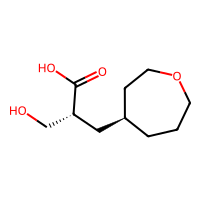
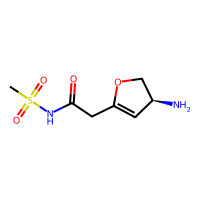
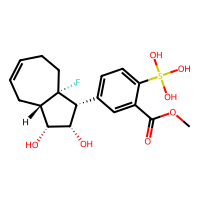
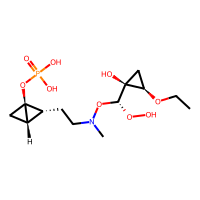
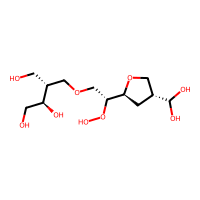

In [10]:
from rdkit.Chem import Draw
from io import BytesIO
import base64
from IPython.display import HTML, display

def mol_to_img_html(smiles, size=(200,200)):
    """Converts a SMILES string to an HTML image tag using RDKit."""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return ""
    img = Draw.MolToImage(mol, size=size)
    buffered = BytesIO()
    img.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    html_img = f'<img src="data:image/png;base64,{img_str}" style="width:{size[0]}px;height:{size[1]}px;">'
    return html_img

def generative_passed_label(row):
    passed_design = row["rule_of_generative_design"] == 1
    passed_strict = row["rule_of_generative_design_strict"] == 1
    if passed_design and passed_strict:
        return "Both"
    elif passed_design:
        return "Generative Design"
    elif passed_strict:
        return "Generative Design Strict"
    else:
        return ""

# Use the same ordering as the interactive heatmap's Generative Focus view.
# That ordering sorts the full DataFrame by gen_design_score and n_filters_pass (both descending).
df_sorted_gen = df.sort_values(["gen_design_score", "n_filters_pass"], ascending=[False, False])

# Now filter for compounds that pass at least one generative filter.
df_generative_ordered = df_sorted_gen[
    (df_sorted_gen["rule_of_generative_design"] == 1) | 
    (df_sorted_gen["rule_of_generative_design_strict"] == 1)
].copy()

# Create a column with the label indicating which generative test(s) were passed.
df_generative_ordered["Generative Test Passed"] = df_generative_ordered.apply(generative_passed_label, axis=1)

# Create a new column with the HTML 2D image.
df_generative_ordered["Molecule Image"] = df_generative_ordered["smiles"].apply(mol_to_img_html)

# Select the columns we want to display.
df_display = df_generative_ordered[["compound_id", "smiles", "Molecule Image", "Generative Test Passed"]]

# Convert the DataFrame to HTML and display.
html_table = df_display.to_html(escape=False, index=False)
display(HTML(html_table))


## Re-dock & Re-score the ligand to the pocket (potentially more realistic pose even with MM)

Prepare the receptor (pdb --> pdbqt) 

1. Copy the pdbqt file to /VFU/config
2. Prepare the docking grid using MGLtools

In [11]:
import os
os.chdir('/home/conrad/virtual_screen/Development_modules/VFU')

from run_vf_unity import main
import pandas as pd

# Redocking parameters
program_choice   = 'qvina'
scoring_function = ''
center_x         = 114.817
center_y         = 75.602
center_z         = 82.416
size_x           = 38
size_y           = 70
size_z           = 58
exhaustiveness   = 10
is_selfies       = False
is_peptide       = False
receptor         = './config/NS5_test.pdbqt'

# List to store redocking results
results = []

# Loop over all compounds in the DataFrame (df_generative_ordered)
for idx, row in df_generative_ordered.iterrows():
    compound_id = row["compound_id"]
    smi = row["smiles"]
    
    print(f"Redocking compound {compound_id} with SMILES: {smi}")
    
    try:
        # Run the redocking process for the current compound
        pose_pred_out, re_scored_values = main(
            program_choice,
            scoring_function,
            center_x,
            center_y,
            center_z,
            size_x,
            size_y,
            size_z,
            exhaustiveness,
            smi,
            is_selfies,
            is_peptide,
            receptor
        )
    except Exception as e:
        print(f"Error redocking compound {compound_id}: {e}")
        pose_pred_out = None
        re_scored_values = None
        
    # Remove ligands folder before copying new outputs.
    os.system('rm -rf ligands')
    
    # Save the outputs in a unique folder named after the compound identifier
    os.system(f'cp -a outputs outputs_{compound_id}')
    
    # Append the results along with compound information
    results.append({
        "compound_id": compound_id,
        "smiles": smi,
        "pose_pred_out": pose_pred_out,
        "re_scored_values": re_scored_values
    })

# Convert the results list into a DataFrame
results_df = pd.DataFrame(results)

# Save the DataFrame to a CSV file
results_df.to_csv("redocking_results.csv", index=False)
print("Redocking results saved to redocking_results.csv")

Redocking compound NS5_ligand_10 with SMILES: O=C(O)[C@@H](CO)C[C@@H]1CCCOCC1
Redocking compound NS5_ligand_14 with SMILES: CS(=O)(=O)NC(=O)CC1=C[C@H](N)CO1
Redocking compound NS5_ligand_15 with SMILES: COC(=O)c1cc([C@@H]2[C@H](O)[C@H](O)[C@@H]3CC=CCC[C@@]23F)ccc1S(O)(O)O
Redocking compound NS5_ligand_3 with SMILES: CCO[C@@H]1C[C@@]1(O)[C@H](OO)ON(C)CC[C@@H]1[C@@H]2C[C@]12OP(=O)(O)O
Redocking compound NS5_ligand_6 with SMILES: OC[C@H](COC[C@@H](OO)[C@@H]1C[C@@H](C(O)O)CO1)[C@@H](O)CO
Redocking results saved to redocking_results.csv


In [13]:
import pandas as pd
import ast
import re
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots

# Read the CSV file
df = pd.read_csv("/home/conrad/virtual_screen/Development_modules/VFU/redocking_results.csv")

# Get the complete list of compound IDs from the CSV so every compound appears on the x-axis
all_compounds = df["compound_id"].unique().tolist()

#########################################
# Process Docking Scores (Top Panel)
#########################################
docking_data = []
for _, row in df.iterrows():
    compound = row["compound_id"]
    pose_str = row["pose_pred_out"]
    # If the field is missing or empty, record a None value so the compound appears
    if pd.isna(pose_str) or pose_str.strip() == "":
        docking_data.append({"compound_id": compound, "docking_score": None})
        continue
    try:
        # Convert the string representation to a dictionary
        pose_dict = ast.literal_eval(pose_str)
    except Exception as e:
        print(f"Error parsing pose_pred_out for {compound}: {e}")
        docking_data.append({"compound_id": compound, "docking_score": None})
        continue
    has_score = False
    for pose_key, value in pose_dict.items():
        # Expect value to be a list whose first element is a list of scores
        if isinstance(value, list) and len(value) > 0 and isinstance(value[0], list):
            scores = value[0]
            for score in scores:
                docking_data.append({"compound_id": compound, "docking_score": score})
                has_score = True
    if not has_score:
        docking_data.append({"compound_id": compound, "docking_score": None})

docking_df = pd.DataFrame(docking_data)

#########################################
# Process Redock Predicted Affinity (Bottom Panel)
#########################################
def parse_kd(kd_str):
    """
    Parse a string like "Kd = 10.16 uM" (or with µM) and convert it to nM.
    Conversions: mM -> 1e6 nM, uM -> 1e3 nM, nM -> 1, pM -> 1e-3 nM, fM -> 1e-6 nM.
    """
    kd_str = kd_str.replace("µ", "u")
    pattern = r'Kd\s*=\s*([\d\.]+)\s*([munpfM]+)'
    match = re.search(pattern, kd_str)
    if match:
        value = float(match.group(1))
        unit = match.group(2).lower()
        if unit == "mm":
            factor = 1e6
        elif unit == "um":
            factor = 1e3
        elif unit == "nm":
            factor = 1
        elif unit == "pm":
            factor = 1e-3
        elif unit == "fm":
            factor = 1e-6
        else:
            factor = 1
        return value * factor
    return None

rescored_data = []
for _, row in df.iterrows():
    compound = row["compound_id"]
    rescore_str = row["re_scored_values"]
    # Handle missing affinity data
    if pd.isna(rescore_str) or rescore_str.strip() == "":
        rescored_data.append({"compound_id": compound, "pose_file": None, "kd_nM": None})
        continue
    try:
        rescore_dict = ast.literal_eval(rescore_str)
    except Exception as e:
        print(f"Error parsing re_scored_values for {compound}: {e}")
        rescored_data.append({"compound_id": compound, "pose_file": None, "kd_nM": None})
        continue
    has_val = False
    for pose_file, kd_list in rescore_dict.items():
        if isinstance(kd_list, list):
            for kd_str in kd_list:
                kd_value = parse_kd(kd_str)
                if kd_value is not None:
                    rescored_data.append({"compound_id": compound, "pose_file": pose_file, "kd_nM": kd_value})
                    has_val = True
    if not has_val:
        rescored_data.append({"compound_id": compound, "pose_file": None, "kd_nM": None})

rescored_df = pd.DataFrame(rescored_data)

#########################################
# Convert Kd (in nM) to pKd
#########################################
# pKd = -log10(Kd in M). Since Kd is in nM, then pKd = 9 - log10(Kd in nM)
def compute_pKd(kd_nM):
    if kd_nM is None or pd.isna(kd_nM) or kd_nM <= 0:
        return None
    return 9 - np.log10(kd_nM)

rescored_df["pKd"] = rescored_df["kd_nM"].apply(compute_pKd)

#########################################
# Create Combined Interactive Plots with Shared X-axis
#########################################
combined_fig = make_subplots(
    rows=2,
    cols=1,
    shared_xaxes=True,
    subplot_titles=(
        "Docking Scores per Compound",
        "Redock Predicted Affinity (pKd) per Compound"
    )
)

# Top Panel: Boxplot for docking scores
fig_box = px.box(
    docking_df,
    x="compound_id",
    y="docking_score",
    category_orders={"compound_id": all_compounds},
    labels={"compound_id": "Compound ID", "docking_score": "Docking Score"}
)
fig_box.update_traces(marker=dict(color='royalblue'), boxmean=True)

# Bottom Panel: Boxplot for pKd values
fig_pkd = px.box(
    rescored_df,
    x="compound_id",
    y="pKd",
    category_orders={"compound_id": all_compounds},
    labels={"compound_id": "Compound ID", "pKd": "pKd"}
)
fig_pkd.update_traces(marker=dict(color='darkorange'), boxmean=True)

# Add traces to the combined figure
for trace in fig_box.data:
    combined_fig.add_trace(trace, row=1, col=1)
for trace in fig_pkd.data:
    combined_fig.add_trace(trace, row=2, col=1)

# Update layout: shared x-axis, rotated tick labels
combined_fig.update_layout(height=900, showlegend=False)
combined_fig.update_xaxes(tickangle=-45)
combined_fig.show()
